[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KDSource/KDSource/blob/master/docs/source/Tutorial.ipynb)

# Tutorial

This tutorial shows the basic usage of the KDSource tool.

Usually, the starting point is a particle list recorded somewhere in a Monte Carlo simulation, e.g. when passing through a given surface. In this example we will use a synthetic particle list generated from a known analytical distribution instead.

We will then fit a KDE source on the particle list using the KDSource class, and save the optimized model as a KDSource XML file.

Finally, we will use the generated file to generate an arbitrary number of new particles, which will follow the estimated distribution of the original particle list. They will be saved into a new MCPL file, from which they can be converted to several Monte Carlo formats.

## Install KDSource

First of all, we install KDSource on the Google Colab virtual machine. Estimated time: 1 min

Skip this cell if KDSource is already installed and available in your PATH (installation instructions [here](https://kdsource.readthedocs.io/en/latest/installation.html)).

In [ ]:
def install_kdsource():
    #
    # Clone source code from Github, make and install
    #
    
    import os
    
    if not os.path.isdir('/content'):
        print("This function installs KDSource in a Google Colaboratory instance.")
        print("For local installation instructions see:")
        print("https://kdsource.readthedocs.io/en/latest/installation.html")
        return
    
    %cd -q /content
    print("Obtaining KDSource source code from Github...")
    !git --no-pager clone --recurse-submodules https://github.com/KDSource/KDSource &> /dev/null
    %cd -q KDSource
    !git --no-pager checkout master &> /dev/null
    !mkdir build
    %cd -q build
    print("Running cmake...")
    !cmake .. -DCMAKE_INSTALL_PREFIX=/usr/local/KDSource &> /dev/null
    print("Running make install...")
    !make install &> /dev/null
    print("Installing Python API...")
    %cd -q ../python
    !pip install . &> /dev/null
    
    os.environ['PATH'] += ":/usr/local/KDSource/bin"
    
    %cd -q /content

from time import time
t1 = time()
install_kdsource()
t2 = time()
print("Installed KDSource in {:.2f} minutes".format((t2-t1)/60.0))


## Generate synthetic data

In this section we will generate the synthetic particle list. We will use the following joint distribution:

$$f(u,x,y,z,\mu,\varphi)=\left(f_{u,1}(u)f_{x,1}(x)+f_{u,2}(u)f_{x,2}(x)\right)f_y(y)\ f_{\mu}(\mu)\ f_{\varphi}(\varphi)$$

Being $u=log(E_0/E)$ the lethargy, $(x,y)$ the 2D position ($z$ is fixed at 0), and $\mu=cos(\theta),\varphi$ the polar coordinates, so that $\hat{\Omega}=(d_x,d_y,d_z)=(sin(\theta)cos(\varphi),sin(\theta)sin(\varphi),cos(\theta))$ is the direction unit-vector.

The specific distributions for each variable are described as follows: 

*   Lethargy: Normal distribution for lethargy:

    $$f_{u,i}(u)=\frac{1}{\sigma_u\sqrt{2\pi}}exp\left(-\frac{(u-\mu_{u,i})^2}{2\sigma_u^2}\right),\ i=1,2$$

*   Position: Normal distribution for x. Normal distribution around 0 for y. Fixed z = 0:

    $$f_{x,i}(x)=\frac{1}{\sigma_x\sqrt{2\pi}}exp\left(-\frac{(x-\mu_{x,i})^2}{2\sigma_x^2}\right),\ i=1,2,\ f_y(y)=\frac{1}{\sigma_y\sqrt{2\pi}}exp\left(-\frac{y^2}{2\sigma_y^2}\right)$$

* Direction: "Cosine distribution", uniform in $\varphi$:

    $$f_{\mu}(\mu)=2\mu,\ \mu>0,\ f_{\varphi}(\varphi)=\frac{1}{2\pi}$$

* Weight: Normal distribution around 1.

    $$f(w)=\frac{1}{\sigma_w\sqrt{2\pi}}exp\left(-\frac{(w-1)^2}{2\sigma_w^2}\right)$$

    with &sigma;<sub>w</sub> small enough so that w is always greater than 0.

We can see that there are two gaussian "clusters" of particles, on the $u-x$ plane, each one with a characteristic lethargy and x distribution, implying that thess variables are correlated. The other variables have a separated density distribution.

Along this tutorial we will show plots of this distribution for more clarity.


In [1]:
import os
import numpy as np
import kdsource as kds
import mcpl

N = int(1E5) # Size of particle list

pt = "n"     # Particle type: neutron

# Generate energies
E0 = 10.0
sigma_u = 1
mu_u_1 = 5
mu_u_2 = 9
us_1 = np.random.normal(mu_u_1, sigma_u, (int(N/2),1))
us_2 = np.random.normal(mu_u_2, sigma_u, (int(N/2),1))
us = np.concatenate((us_1, us_2), axis=0)
Es = E0 * np.exp(-us)

# Generate positions
sigma_x = sigma_y = 10
mu_x_1 = sigma_x
mu_x_2 = -sigma_x
poss_1 = np.random.normal([mu_x_1,0,0], [sigma_x,sigma_y,0], (int(N/2),3))
poss_2 = np.random.normal([mu_x_2,0,0], [sigma_x,sigma_y,0], (int(N/2),3))
poss = np.concatenate((poss_1, poss_2), axis=0)

# Generate directions
mus = np.sqrt(np.random.uniform(0,1,N))
phis = np.random.uniform(-np.pi,np.pi,N)
dxs = np.sqrt(1-mus**2) * np.cos(phis)
dys = np.sqrt(1-mus**2) * np.sin(phis)
dzs = mus
dirs = np.stack((dxs,dys,dzs), axis=1)

# Stack energies, positions and directions and shuffle
parts = np.concatenate((Es,poss,dirs), axis=1)
np.random.shuffle(parts)

# Generate weights
sigma_w = 0.1
ws = np.random.normal(1, sigma_w, N)

# Save array of particles to SSV text file and convert it to MCPL
ssvfile = "samples.ssv"
kds.savessv(pt, parts, ws, ssvfile)
!ssv2mcpl $ssvfile samples
samples = "samples.mcpl.gz"

Writing particles into SSV file...
Done. All particles written into samples.ssv
ssv_open_file: Opened file "samples.ssv":
MCPL: Attempting to compress file samples.mcpl with gzip
MCPL: Succesfully compressed file into samples.mcpl.gz
Created samples.mcpl.gz


## Create and optimize KDSource

In this section we will create a KDSource object and fit the KDE source model to the generated particle list, i.e., optimize its bandwidth.

The KDSource tool uses the Adaptive Multivariate Kernel Density Estimator to estimate the source density:
$$
\hat{f}(\textbf{x}) = \hat{f}(x_{1},x_{2},...,x_{D}) =
    \sum_{\rm i=1}^{N} w_{\rm i} \left
      \{\prod_{\rm j=1}^{D}\frac{1}{h_i}
      K\left(\frac{x_{\rm j}-(p_{\rm i})_{\rm  j}}{s_j h_i}\right) \right \} 
    \label{eq:multiD}
$$

Where:
* $x$ is the phase-vector defining a source particle (with optional changes of variables).
* $p_i$ is the i-th particle in the particle list.
* $w_i$ is the weight corresponding to the i-th particle in the particle list.
* $K$ is the kernel function (standard gaussian).
* $h_i$ is the bandwidth corresponding to the i-th particle in the particle list.
* $s_j$ is the scaling factor for variable $j$, which by default is the standard deviation of the component $j$ of the particle list. 

### Create KDSource

In [2]:
# PList: wrapper for MCPL file
plist = kds.PList(samples)
# Geometry: define changes of variables
geom = kds.Geometry([kds.geom.Lethargy(E0),
                     kds.geom.SurfXY(),
                     kds.geom.Isotrop()])
# Create KDSource
s = kds.KDSource(plist, geom)

Using existing file samples.mcpl.gz
sum_weights = 100004.73208379745
p2 = 101014.24136501043
N = 100000
N_eff = 99005.31156804055


### Optimize bandwidth

Before bandwidth optimization, we can optionally set variable importances. Setting a value greater than one for a given variable improves the quality of the estimation along that dimension, at the expense of a coarser estimation on the other variables.

In this example we will set a higher importance to the energy.

In [3]:
# Set importances
var_importance = [3,1,1,1,1,1]

# Calculate scalings as std / var_imp
parts,ws = s.plist.get(N=-1)
scaling = s.geom.std(parts=parts)
scaling /= var_importance

Number of particles to use for fitting.

We will use -1, which means use all particles in the list.

In [4]:
N = -1

There are 3 available bandwidth optimization methods. Choose one and run its cell to optimize bandwidth.

Recommended method is Method 3 (adaptive MLCV).

* Method 1: Silverman's Rule: Simple and fast method.

    BW is chosen based on only on the number of particles, and dimension of geometry.
    
    Estimated time: 1 sec

In [5]:
s.bw_method = "silv"
s.fit(N, scaling=scaling)

Using 100000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.2201611  4.18782561 2.94708232 0.13943096 0.13943096 0.13943096]]


* Method 2: Non-adaptive Maximum Likelihood Cross-Validation: Intermediate method
    
    Creates a grid of bandwidths and evaluates the MLCV Figure of Merit (FoM) on each one. Selects the bandwidth that optimizes CV score.
    
    Estimated time: 1 min

Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.1s remaining:   28.3s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   12.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.0s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished


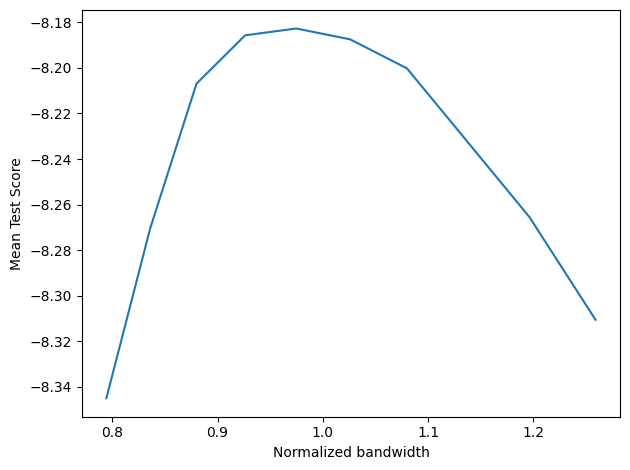

Done
Optimal bw (mlcv) = [[0.27016257 5.13893575 3.61640339 0.17109756 0.17109756 0.17109756]]
Using 100000 particles for fit.


In [6]:
s.bw_method = "mlcv"
seed = None # Default: Use the Silverman's Rule as seed
grid = np.logspace(-0.1,0.1,10)

N_cv = int(1E4) # Use a smaller N to reduce computation times
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)

bw = s.kde.bw
dim = s.geom.dim
bw *= kds.kde.bw_silv(dim,N)/kds.kde.bw_silv(dim,N_cv) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw) # Create new KDSource with adapted BW
s.fit(N=N, scaling=scaling)

* Method 3: Adaptive Maximum Likelihood Cross-Validation: Most precise method, but also longest to compute.
    
    Uses kNN is to generate a seed adaptive bandwidth. Then creates a grid of adaptive bandwidths by scaling the seed bandwidth, and evaluates the MLCV Figure of Merit (FoM) on each one. Selects the bandwidth that optimizes CV score.
    
    Estimated time: 3 min

Using 100000 particles for fit.
Calculating bw ... 
Using k = 10 neighbors per batch (batch_size = 10000)
Correction factor: f_k = k_float / k = 1.0
Effective total neighbors: K_eff = 100.0
batch = 1 / 10
batch = 2 / 10
batch = 3 / 10
batch = 4 / 10
batch = 5 / 10
batch = 6 / 10
batch = 7 / 10
batch = 8 / 10
batch = 9 / 10
batch = 10 / 10
Done
Optimal bw (knn) = [[ 0.52417891  9.97074369  7.0166729   0.3319695   0.3319695   0.3319695 ]
 [ 0.91796958 17.46128888 12.2879653   0.58136239  0.58136239  0.58136239]
 [ 0.77034101 14.65315116 10.31180541  0.48786725  0.48786725  0.48786725]
 ...
 [ 0.69440275 13.2086807   9.2952938   0.43977453  0.43977453  0.43977453]
 [ 0.69445723 13.20971694  9.29602302  0.43980903  0.43980903  0.43980903]
 [ 0.57294049 10.89826904  7.66939673  0.36285086  0.36285086  0.36285086]]
Using 10000 particles for fit.
Calculating bw ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   25.3s remaining:   59.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   28.1s remaining:   28.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.2s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.9s finished


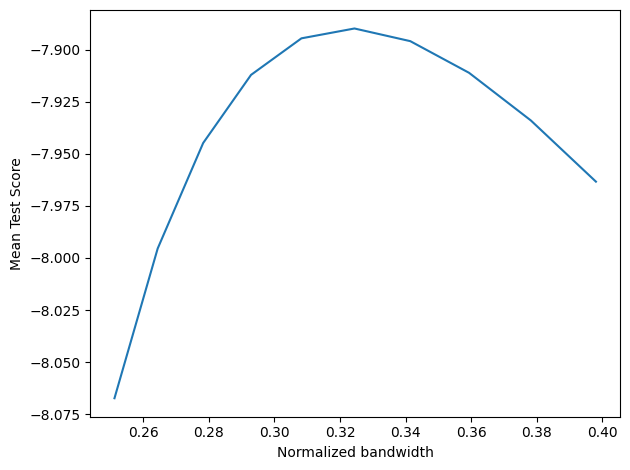

Done
Optimal bw (mlcv) = [[0.17005549 3.23473467 2.27636732 0.10769841 0.10769841 0.10769841]
 [0.29781008 5.66483688 3.98649375 0.1886071  0.1886071  0.1886071 ]
 [0.24991604 4.75381351 3.3453828  0.15827516 0.15827516 0.15827516]
 ...
 [0.24193451 4.6019916  3.23854175 0.15322035 0.15322035 0.15322035]
 [0.14489199 2.75608368 1.93952811 0.09176203 0.09176203 0.09176203]
 [0.1723162  3.27773712 2.30662927 0.10913015 0.10913015 0.10913015]]
Using 100000 particles for fit.


In [7]:
# kNN bandwidth
s.bw_method = "knn"
batch_size = 10000 # Batch size for KNN search
k = 10             # Numer of neighbors per batch
s.fit(N, scaling=scaling, batch_size=batch_size, k=k)
bw_knn = s.kde.bw

# MLCV optimization of previously calculated kNN bandwidth
s.bw_method = "mlcv"
N_cv = int(1E4)   # Use a smaller N to reduce computation times
seed = bw_knn[:N_cv] # Use kNN BW as seed (first N elements)
grid = np.logspace(-0.6,-0.4,10)
s.fit(N_cv, scaling=scaling, seed=seed, grid=grid)
bw_cv = s.kde.bw

# Extend MLCV optimization to full KNN BW
bw_knn_cv = bw_knn * bw_cv[0]/bw_knn[0] # Apply MLCV factor
dim = s.geom.dim
bw_knn_cv *= kds.kde.bw_silv(dim,len(bw_knn))/kds.kde.bw_silv(dim,len(bw_cv)) # Apply Silverman factor
s = kds.KDSource(plist, geom, bw=bw_knn_cv) # Create new KDSource with full BW
s.fit(N=N, scaling=scaling)

## Save KDSource model

We now save our optimized model as a KDSource XML file.

The XML file will contain the KDSource model parameters, and the path to the original particle list MCPL file.

If an adaptive bandwidth was chosen, the list of bandwidths will be saved as a separate binary file and its path will be included in the KDSource XML file. 

In [8]:
xmlfile = "source.xml" # KDSource XML file name

s.save(xmlfile) # Save KDSource to XML file
if os.name == 'posix':
    !cat $xmlfile
if os.name == 'nt':
    !type $xmlfile

Bandwidth file: samples_bws
Successfully saved parameters file source.xml
<?xml version="1.0" ?>
<KDSource>
	<J units="1/s">1.0</J>
	<PList>
		<pt>n</pt>
		<mcplname>/media/inti/Disco local/Users/Osiris Inti Abbate/Documents/Universidad/KDSource/Windows/KDinstall/docs/source/samples.mcpl.gz</mcplname>
		<trasl/>
		<rot/>
		<x2z>0</x2z>
	</PList>
	<Geom order="3">
		<Lethargy>
			<dim>1</dim>
			<params nps="1">10.0</params>
		</Lethargy>
		<SurfXY>
			<dim>2</dim>
			<params nps="5">-inf inf -inf inf 0</params>
		</SurfXY>
		<Isotrop>
			<dim>3</dim>
			<params nps="3">0 0 0</params>
		</Isotrop>
		<trasl/>
		<rot/>
	</Geom>
	<scaling> 0.7454344  14.1793864   9.97840476  0.47209355  0.47209355  0.47209355</scaling>
	<BW variable="1">/media/inti/Disco local/Users/Osiris Inti Abbate/Documents/Universidad/KDSource/Windows/KDinstall/docs/source/samples_bws</BW>
</KDSource>


## Generate particles

We can start generating particles!

Using the command `kdtool resample` we can generate an arbitrary number of particles following the estimated source distribution and save them in a new MCPL file.

In [9]:
N_resampled = 1E6 # Number of particles to generate with virtual KDE source

if os.name == 'posix':
    !kdtool resample "$xmlfile" -o "resampled" -n $N_resampled
if os.name == 'nt': # kdtool still not implemented in Windows
    !kdtool-resample "$xmlfile" -o "resampled" -n $N_resampled
resampled = "resampled.mcpl.gz"

Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file resampled.mcpl with gzip
MCPL: Succesfully compressed file into resampled.mcpl.gz
Successfully sampled 1000000 particles.


A new MCPL file has been created, named "resampled.mcpl.gz", with particles generated from the KDE-based distribution.

## Create plots

We now want to compare the estimated distribution with the original true distribution, to verify they match.

Since in this example the original distribution is known, we will directly use its analytical functions. In a real problem the true source density is unknown, so we would use histograms of the original particle list instead.

On the other hand, there are two ways to show the estimated distribution:
1. Using the evaluation and plotting functions of the KDSource Python API. This implies actually evaluating the formula KDE estimator. The evaluating algorithm can be some time consuming.
2. Using histograms of generated particles. This way we check the actual distribution of the particles sampled from the source.

Comparison will be performed both visually and quantitatively, based on the Kullback-Leibler divergence.

In [10]:
import matplotlib.pyplot as plt

Define some functions

In [11]:
# KL divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Histogram of MCPL particle list
def mcpl_hist(mcplfile, var, bins, part0=None, part1=None, **kwargs):
    pl = mcpl.MCPLFile(mcplfile)
    hist = np.zeros(len(bins)-1)
    I = 0
    for pb in pl.particle_blocks:
        parts = np.stack((pb.ekin,pb.x,pb.y,pb.z,pb.ux,pb.uy,pb.uz), axis=1)
        mask1 = np.ones(len(parts), dtype=bool)
        if part0 is not None:
            mask1 = np.logical_and.reduce(part0 <= parts, axis=1)
        mask2 = np.ones(len(parts), dtype=bool)
        if part1 is not None:
            mask2 = np.logical_and.reduce(parts <= part1, axis=1)
        mask = np.logical_and(mask1, mask2)
        data = parts[mask][:,var]
        hist += np.histogram(data, bins=bins, weights=pb.weight[mask], **kwargs)[0]
        I += np.sum(pb.weight)
    hist /= I
    hist /= (bins[1:]-bins[:-1])
    return hist

### Energy / lethargy plots

In [12]:
EE = np.logspace(-4,0,50)

# Analytic distributions
uu = s.geom.ms[0].transform(EE)
pdf_1 = 0.5 * 1/EE*np.exp(-(uu-mu_u_1)**2/(2*sigma_u**2))/(sigma_u*np.sqrt(2*np.pi))
pdf_2 = 0.5 * 1/EE*np.exp(-(uu-mu_u_2)**2/(2*sigma_u**2))/(sigma_u*np.sqrt(2*np.pi))
f = 0.1587 # Integral of normal distribution for x-mu>std

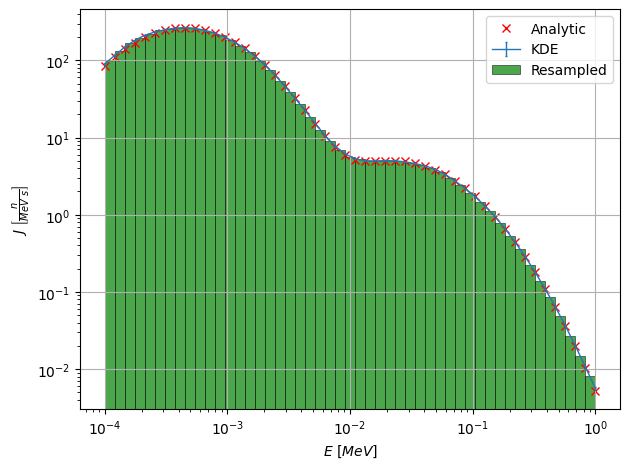

In [13]:
# Plot energy distribution

fig,scores = s.plot_E(EE, label="KDE")

hist = mcpl_hist(resampled, 0, EE)
widths = (EE[1:]-EE[:-1])
plt.bar(EE[:-1], hist, width=widths, align="edge", linewidth=.5, ec="k",
        fc="g", alpha=.7, label="Resampled")

plt.plot(EE, pdf_1+pdf_2, 'xr', zorder=1, label="Analytic")

plt.legend()
plt.tight_layout()
plt.show()

It can be seen that both the KDE curve and the histogram of the generated particles successfully estimate the original distribution.

Using 100 particles for fit.
Using 316 particles for fit.
Using 1000 particles for fit.
Using 3162 particles for fit.
Using 10000 particles for fit.
Using 31622 particles for fit.
Using 100000 particles for fit.


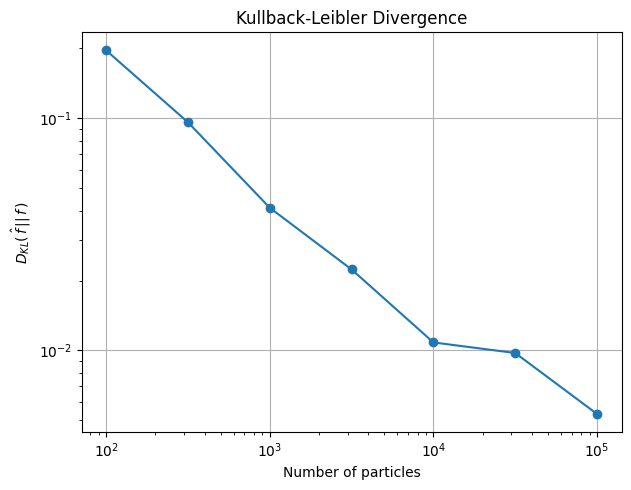

In [14]:
# Plot reduction of KL divergence with growing N

# KL divergence is computed between lethargy distributions
# because energy grid is logarithmic (linear in lethargy)

s.bw_method = None
KLDs = []
n_vals = np.logspace(2,5,7).astype("int")
dim = s.geom.dim
bw = s.kde.bw
N = len(s.kde.bw)
for n in n_vals:
    s.fit(N=n, scaling=scaling)
    s.kde.bw = bw * kds.kde.bw_silv(dim,n)/kds.kde.bw_silv(dim,N)
    fig,[score,err] = s.plot_E(EE, label=f"N = {n}")
    f_u = (pdf_1+pdf_2) * EE # Analytic lethargy distribution
    KDE_u = score * EE       # KDE lethargy distribution
    KLDs.append(kl_divergence(f_u, KDE_u))
plt.clf()

plt.plot(n_vals, KLDs, 'o-')
plt.xlabel('Number of particles')
plt.ylabel('$D_{KL}(\,\hat{f}\,||\,f\,)$')
plt.title('Kullback-Leibler Divergence')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

It can be seen how the KL divergence between the true and estimated distribution decreases with the number of particles. The KL divergence is a measure of the distance between both distributions, so this means that the larger the particle list used in the estimation, the closer is the estimation to the original distribution.

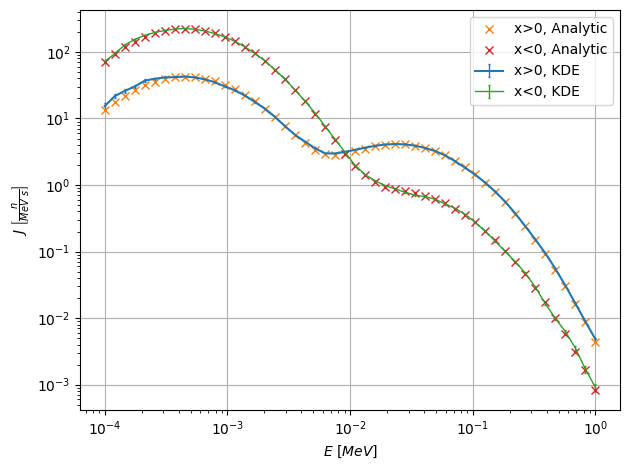

In [15]:
# Plot correlation with x
# We can restrict the x range used in the energy plot,
# and observe the correlation between both variables.

# Vectors to separate x<0 and x>0
# Vec: [u, x,y, dx,dy,dz]
vec0 = [-np.inf,0,-np.inf,-1,-1,-1]
vec1 = [np.inf,0,np.inf,1,1,1]
# Part: [E, x,y,z, dx,dy,dz]
part0 = [0,0,-np.inf,-np.inf,-1,-1,-1]
part1 = [np.inf,0,np.inf,np.inf,1,1,1]

# Plot only particles with x > 0
fig,scores = s.plot_E(EE, vec0=vec0, label="x>0, KDE")
plt.gca().lines[0].set_linewidth(1.5)
plt.plot(EE, (1-f)*pdf_1+f*pdf_2, 'x', linewidth=1.5, label="x>0, Analytic")

# Plot only particles with x < 0
fig,scores = s.plot_E(EE, vec1=vec1, label="x<0, KDE")
plt.gca().lines[0].set_linewidth(1.5)
plt.plot(EE, f*pdf_1+(1-f)*pdf_2, 'x', linewidth=1.5, label="x<0, Analytic")

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Here we observe the effect of restricting the $x$ range in the energy plots. Since energy and $x$ are correlated, restricting the $x$ values affects the energy distribution.

Since the two $u-x$ clusters overlap in $x$, particles with $x>0$ are composed by a big fraction of the cluster with positive mean $x$, but also a small fraction of the other cluster. The energy peaks are thus modified with the respective factors, as can be seen in the plot. The analogous effect happens for particles with $x<0$.

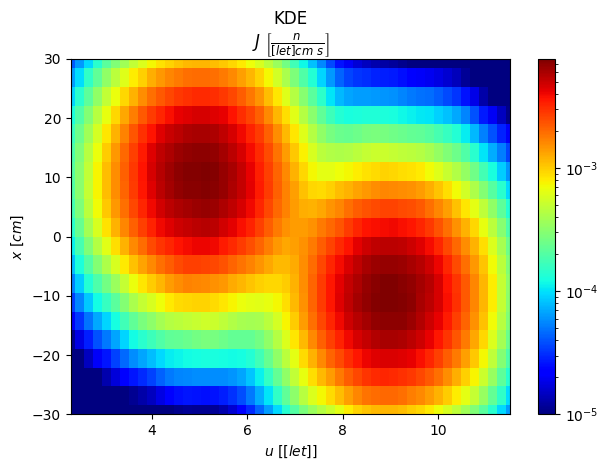

In [16]:
# Lethargy-x 2D plot

xx = np.linspace(-30,30,20)

fig,scores = s.plot2D_integr(["u","x"], [uu,xx], scale="log")

plt.clim(vmin=1e-5)
plt.tight_layout()
plt.show()

### Position plots

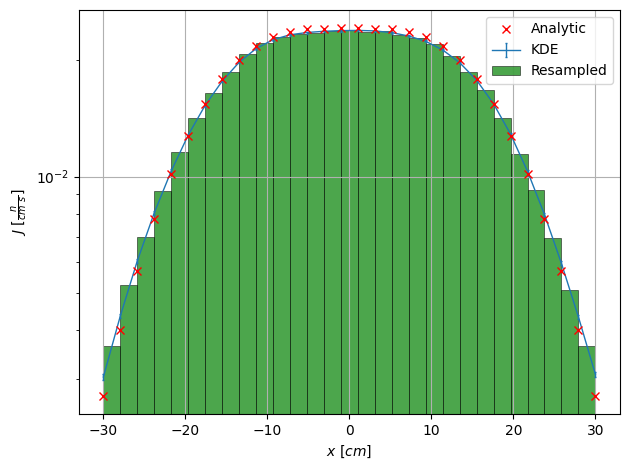

In [17]:
# Plot x distribution

xx = np.linspace(-30,30,30)
pdf_1 = 0.5 * np.exp(-((xx-mu_x_1)/sigma_x)**2/2)/(sigma_x*np.sqrt(2*np.pi))
pdf_2 = 0.5 * np.exp(-((xx-mu_x_2)/sigma_x)**2/2)/(sigma_x*np.sqrt(2*np.pi))

fig,scores = s.plot_integr("x", xx)

hist = mcpl_hist(resampled, 1, xx)
widths = (xx[1:]-xx[:-1])
plt.bar(xx[:-1], hist, width=widths, align="edge", linewidth=.5, ec="k",
        fc="g", alpha=.7, label="Resampled")

plt.plot(xx, pdf_1+pdf_2, 'xr', zorder=3, label="Analytic")

plt.legend()
plt.tight_layout()
plt.show()

We observe again that both the KDE curve and the histogram of resampled particles follow the original distribution. 

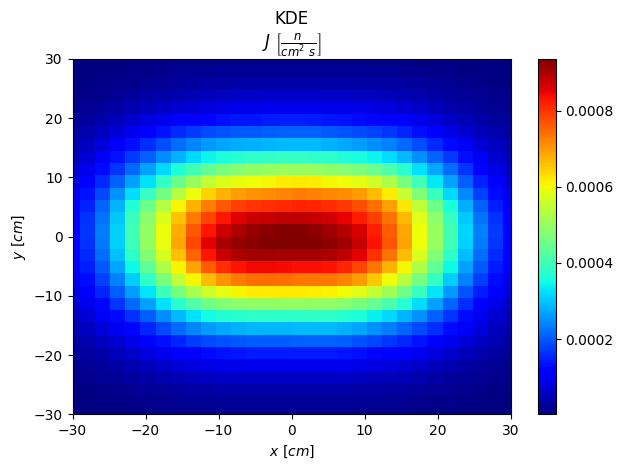

In [18]:
# Plot xy distribution

xx = np.linspace(-30,30,30)
yy = np.linspace(-30,30,30)
fig,scores = s.plot2D_integr(["x","y"], [xx,yy])
plt.tight_layout()
plt.show()

### Direction plots

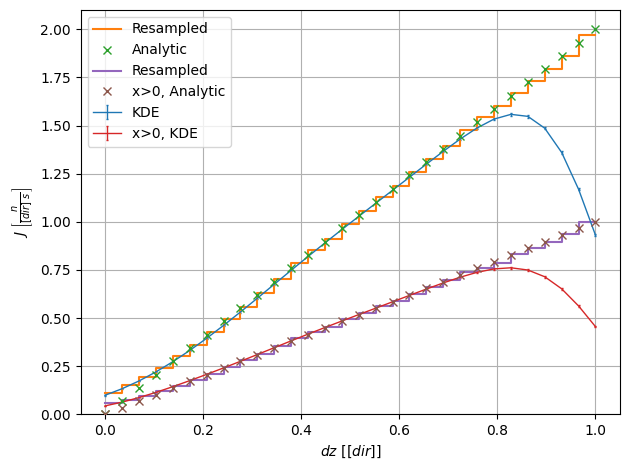

In [19]:
# Plot dz distribution

ddz = np.linspace(0,1,30)
pdf = 2 * ddz

fig,[scores,errs] = s.plot_integr("dz", ddz, yscale="linear")

hist = mcpl_hist(resampled, 6, ddz)
hist = np.concatenate((hist, hist[-1:]))
plt.plot(ddz, hist, ds='steps-post', label="Resampled")

plt.plot(ddz, pdf, 'x', zorder=3, label="Analytic")

fig,[scores,errs] = s.plot_integr("dz", ddz, vec0=vec0, yscale="linear", label="x>0, KDE")

hist = mcpl_hist(resampled, 6, ddz, part0=part0)
hist = np.concatenate((hist, hist[-1:]))
plt.plot(ddz, hist, ds='steps-post', label="Resampled")

plt.plot(ddz, 0.5*pdf, 'x', zorder=3, label="x>0, Analytic")

plt.ylim(bottom=0)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

We here observe the effect of restricting the $x$ range in the $\mu$ plot. Since $\mu$ is not correlated with $x$, its distribution for $x>0$ is the same (linear), but with half the intensity.

Besides, although the Python KDE fails to match the analytic distribution near $dz=1$, due to border effects, the resampled data do match it. This is because the sampling algorithms take into account the nature of the direction vector.

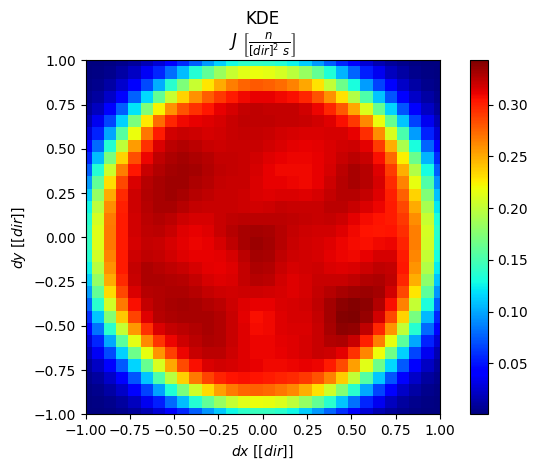

In [20]:
# Plot dx-dy distribution

ddx = np.linspace(-1,1,30)
ddy = np.linspace(-1,1,30)

fig,scores = s.plot2D_integr(["dx","dy"], [ddx,ddy], scale="linear")

plt.gca().set_aspect(1)
plt.tight_layout()
plt.show()

For a cosine distribution, the density projected in the $dx-dy$ plane is uniform.